In [1]:
import sys
sys.path.insert(0, "/Users/aimachine/PyImage/utils")
import numpy as np
from scipy import signal
from scipy.fftpack import fftfreq
from PIL import Image
import os
from plot_utils import multiplot, doubleplot, doubleplotline, multiplotline, overlaymultiplot
from scipy.signal import blackman
from tifffile import imread
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible
from Strip2DFFT import doFilterFFT, do2DFFT, do2DInverseFFT, CrossCorrelation, CrossCorrelationStrip, doFilterFFT, do2DFFT, do2DInverseFFT, FFTStrip

In the block below specify the target directory in which the result images would be written. Specify the full path to the Kymograph image for curvature and intensity to compute auto and cross correlation peaks for both. The axes keyword tells the program that it is seeing an X-Y image

In [2]:
targetdir = '/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/'
#For curvature
sourceimageA = '/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/KymographN5Circle.tif'
#For Intensity
sourceimageB = '/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/ETrackRawTestIntensity.tif'

SaveFileName = "Curvature-Curvature";

base = os.path.split(sourceimageA)[-1]

Filename = os.path.splitext(base)
axes = 'YX'

In the block below we read the two images using custom made imread function for tifffiles and displaying them

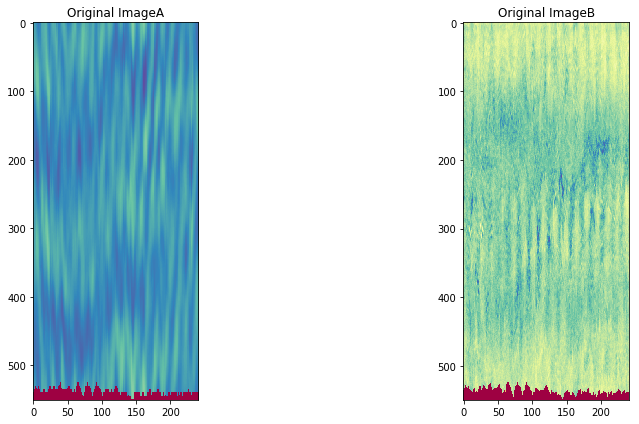

In [3]:
originalimageA = imread(sourceimageA)
originalimageB = imread(sourceimageB)
doubleplot(originalimageA, originalimageB, "Original ImageA", "Original ImageB")

# Fourier Transform of a block of Kymograph

Parameters to be specified:

1) Time_unit = frame to second conversion for the experiment

2) StartSection = Starting of the block at this pixel unit

3) EndSection = Ending of the block at this pixel unit

4) Max Range in hertz for the Fourier transform plot

# Reset block

In [4]:
#Enter start and end y pixel unit for the section
Start_Sec = 0
End_Sec = originalimageA.shape[0]
#Enter start and end x pixel unit for the section
Starttime = 0
Endtime = originalimageA.shape[1]



imageA = originalimageA[Start_Sec:End_Sec, Starttime:Endtime]
imageB = originalimageB[Start_Sec:End_Sec, Starttime:Endtime]

In [5]:
#Enter time unit in seconds
Time_unit = 5
#Enter pixel to micrometer conversion
Xcalibration = 0.212
#Range of Plot in Hertz
maxXrange = 1

Cut the Kymograph from the start to the endsection value as specified above

In [6]:

min = 0;
max = 1;
imageA = normalizeMinMax(imageA, min, max)
imageB = normalizeMinMax(imageB, min, max)

block = End_Sec- Start_Sec
axes = 'YX'
allfrequ = 0
onedimg, frequ = doFilterFFT(imageA, Time_unit, False)
allfrequ=onedimg


Show the FFT image along with the original image and save it as a tiff file in the target directory, also save the 1D projection of the twoDFFT as a png file

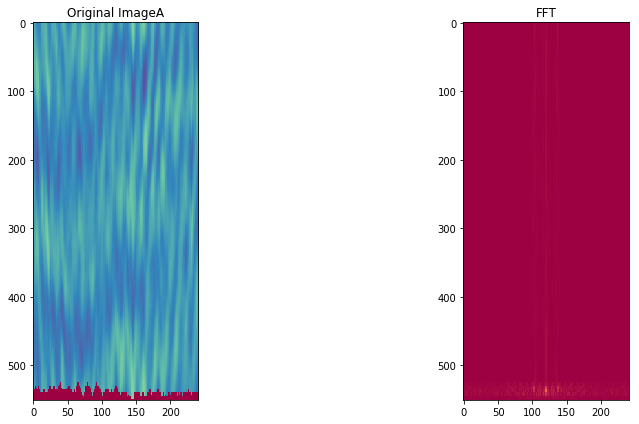

/Users/aimachine/PyImage/utils/Normalize.py:48: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))


Loading BokehJS ...

In [7]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import export_png, output_notebook
TwoDimage = FFTStrip(imageA)
doubleplot(imageA, TwoDimage, "Original ImageA",  "FFT")
save_tiff_imagej_compatible((targetdir + "TwoDFFT" +os.path.basename(Filename[0]) +os.path.basename(Filename[1]) ) , TwoDimage, axes)

#Peak location
veto_frequ = 0.001
mY = np.abs(onedimg) 
mNoZero = mY[frequ > veto_frequ]
peakY = np.max(mNoZero) 
locY = np.argmax(mNoZero) 
frqY = frequ[locY] 




p = figure(title='FFT (hertz)', x_axis_label='Frequency' , y_axis_label='Amplitude')
p.line(frequ, onedimg, legend =  'Frequ =' + str('%.3f'%(1.0/frqY))+'sec', line_width = 2)

output_notebook()
show(p)


# Hough Transform of the Kymograph chosen to compute the wave velocity

In [8]:
import sys
sys.path.insert(0, "/Users/aimachine/PyImage/utils")
import numpy as np
from scipy import signal
import scipy.fftpack as fftpack
from scipy.fftpack import fftfreq
import matplotlib.pyplot as plt
import os
import math
import cv2 as cv
from skimage import data, color, io, img_as_float
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from skimage.feature import canny
from scipy.signal import blackman
from tifffile import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.fftpack import fft
from plot_utils import multiplot
from matplotlib.colors import LogNorm
from skimage.filters import threshold_mean, sobel
from skimage.filters import threshold_otsu, threshold_local
from skimage import feature
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible
from HoughLine import show_hough_linetransform
from HoughLine import show_hough_linetransform, show_ransac_line, watershed_image

Here we specify the slope threshold parameter, which vetos the slopes found by Hough transform below this value, this is to avoid spurious line detections by Hough Transform. Enter the vcalue in angles above which you do not expect to see a line (0 degree is high slope, 90 degree is zero slope, enter value beetween 0 and 90)

# Reset Block

In [9]:
Start_Sec = 200
End_Sec = originalimageA.shape[0] - 50

Starttime = 0
Endtime = originalimageA.shape[1]


imageA = originalimageA[Start_Sec:End_Sec, Starttime:Endtime]
imageB = originalimageB[Start_Sec:End_Sec, Starttime:Endtime]

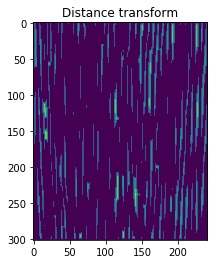

/Users/aimachine/anaconda3/lib/python3.6/site-packages/skimage/segmentation/_join.py:118: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(label_field.dtype, np.int):


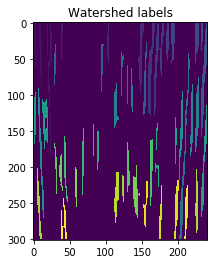

Doing Hough in + [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49] labels


<Figure size 432x288 with 0 Axes>

In [10]:
from skimage import data, io

from skimage.filters import roberts, sobel, scharr, prewitt, gaussian

from skimage.morphology import remove_small_objects, binary_erosion

from bokeh.io import export_png, export_svgs, output_notebook

#If you want to change the start and the end section to only consider highly oscillating regions do so here
#Change the Numeric value of StartSection and EndSection
from bokeh.io import output_file, show
from bokeh.plotting import figure



#Morphological operations on image
min_region_size = 100

binary = gaussian(imageA, 1)

binary = sobel(binary)
thresh = threshold_mean(binary)
binary = binary > thresh

erodetimes = 1
for i in range(erodetimes): 
       binary = binary_erosion(binary)
 
Velocity, Images, Besty0, Besty1 = watershed_image(binary, min_region_size, targetdir, "Hough_Labels",Filename, Xcalibration, Time_unit)


Labels = []
for i in range(len(Velocity)) :
    Labels.append(i)
    
Velocity = np.array(Velocity)    




/Users/aimachine/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


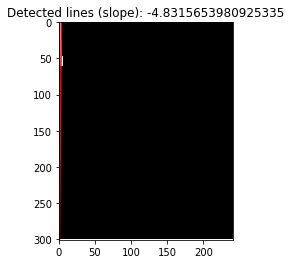

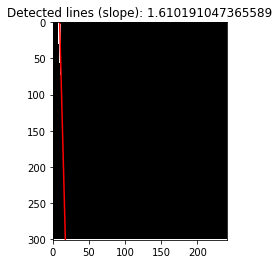

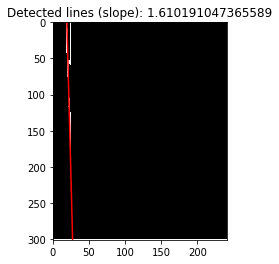

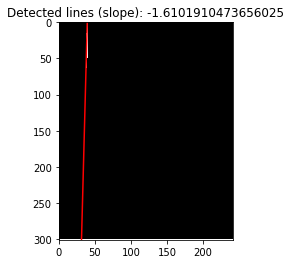

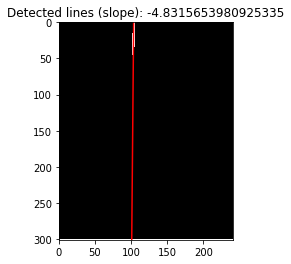

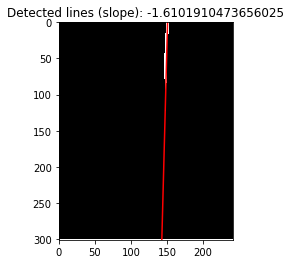

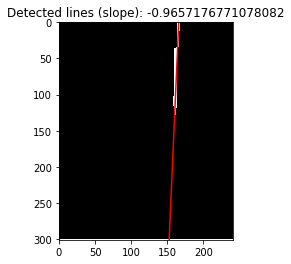

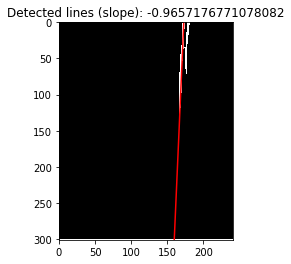

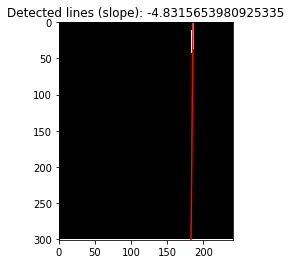

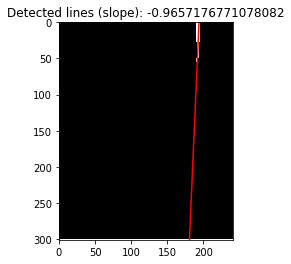

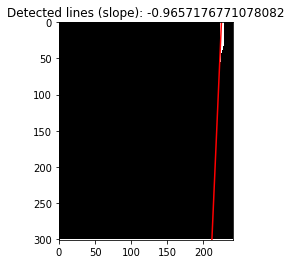

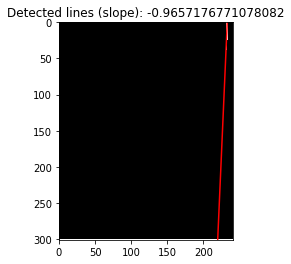

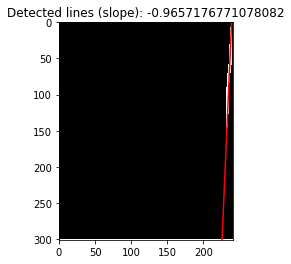

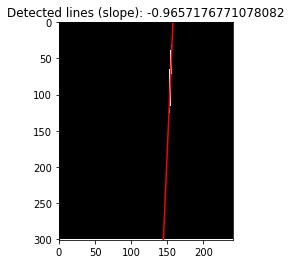

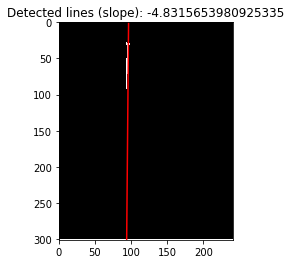

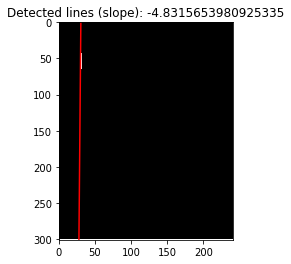

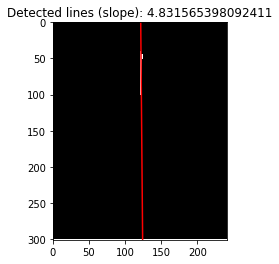

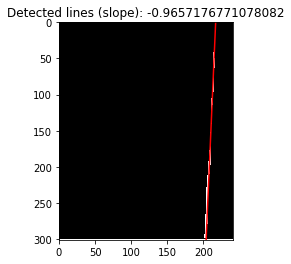

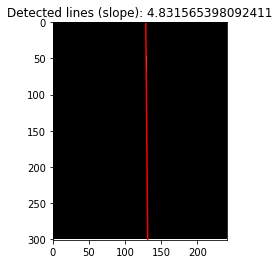

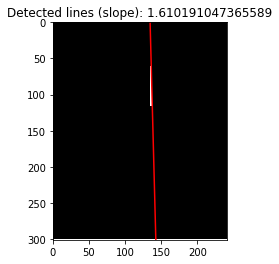

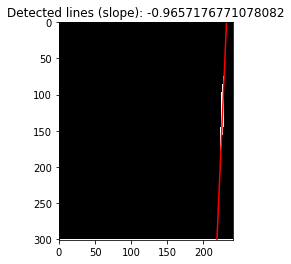

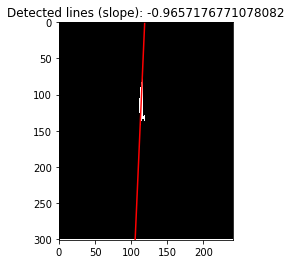

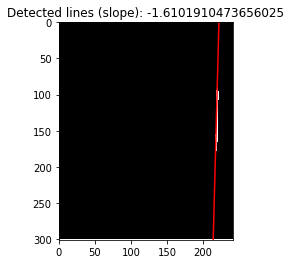

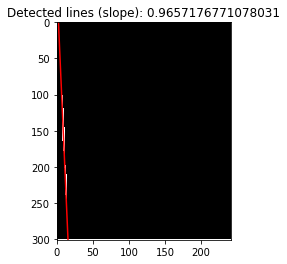

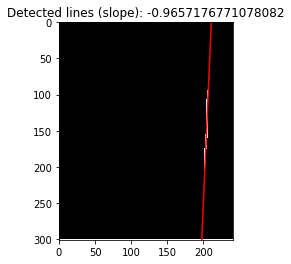

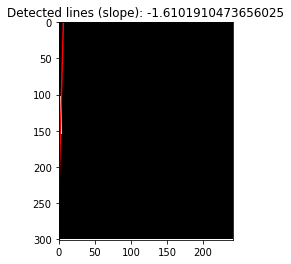

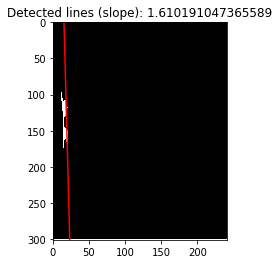

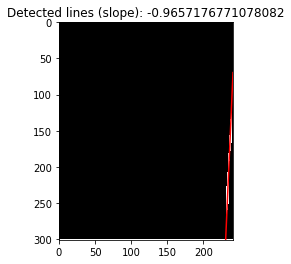

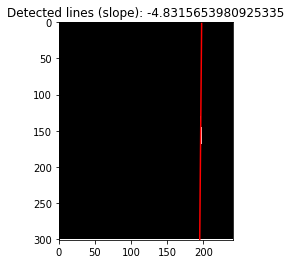

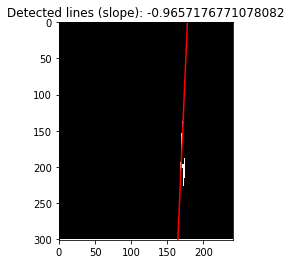

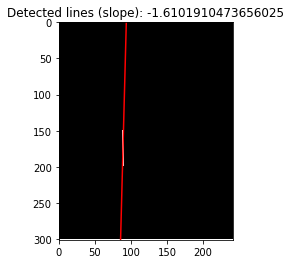

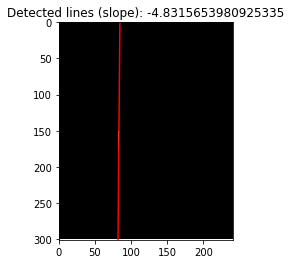

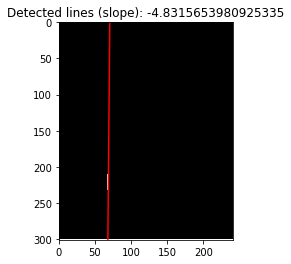

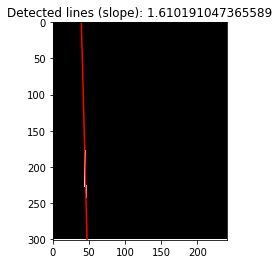

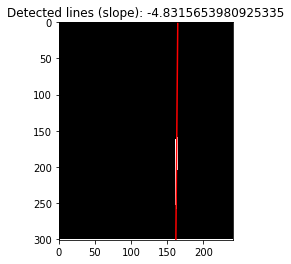

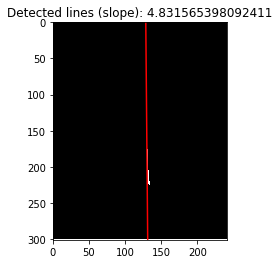

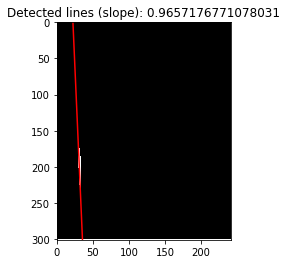

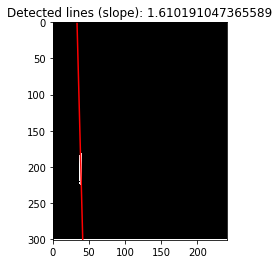

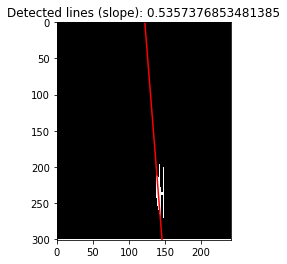

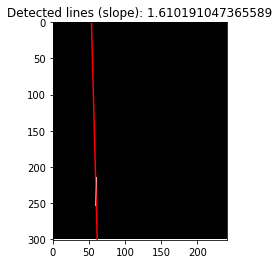

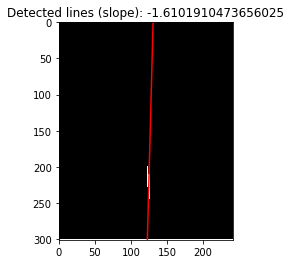

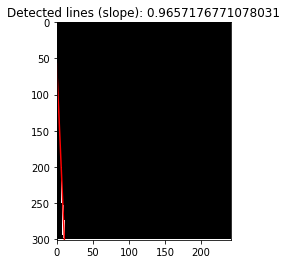

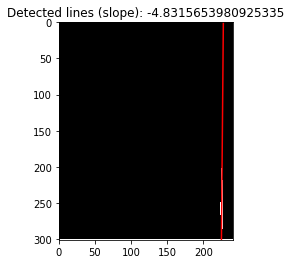

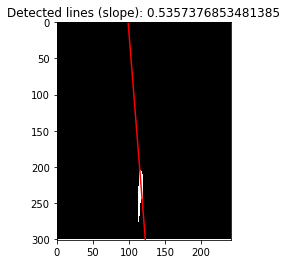

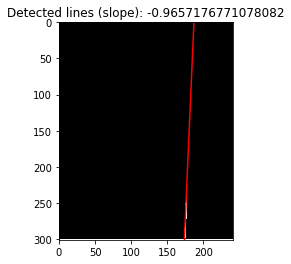

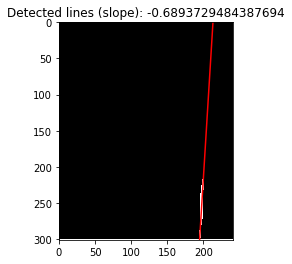

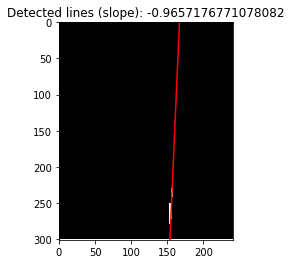

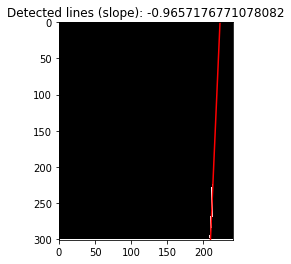

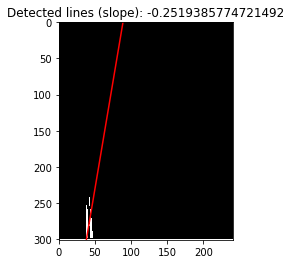

In [11]:
plot_n_detections = 5 #max=len(Images)
for  i in range(0,len(Images)):
 plt.figure(figsize=(16,4))
 plt.imshow(Images[i], cmap=cm.gray)
 plt.plot((0, Images[i].shape[1]), (Besty0[i], Besty1[i]), '-r')
 plt.xlim((0, Images[i].shape[1]))
 plt.ylim((Images[i].shape[0], 0))

 plt.title('Detected lines (slope): '  + str(Velocity[i]))

Now we draw the lines found by Hough Transform and display their values

In [12]:
hist, edges = np.histogram(np.abs(Velocity), density=False, bins=10)
p = figure(title='Wave velocity', y_axis_label='Counts',x_axis_label='Velocity(um/sec)')

p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
    fill_color="#036564", line_color="#033649")
show(p)
print(edges[np.argmax(hist)+1], hist, np.abs(Velocity))

1.167863941596226 [ 4 19 13  0  0  0  0  0  0 13] [4.8315654  1.61019105 1.61019105 1.61019105 4.8315654  1.61019105
 0.96571768 0.96571768 4.8315654  0.96571768 0.96571768 0.96571768
 0.96571768 0.96571768 4.8315654  4.8315654  4.8315654  0.96571768
 4.8315654  1.61019105 0.96571768 0.96571768 1.61019105 0.96571768
 0.96571768 1.61019105 1.61019105 0.96571768 4.8315654  0.96571768
 1.61019105 4.8315654  4.8315654  1.61019105 4.8315654  4.8315654
 0.96571768 1.61019105 0.53573769 1.61019105 1.61019105 0.96571768
 4.8315654  0.53573769 0.96571768 0.68937295 0.96571768 0.96571768
 0.25193858]


# AutoCorrelation and CrossCorrelation between Curvature and Intensity Kymograph

# Reset block

In [13]:
Start_Sec = 0
End_Sec = originalimageA.shape[0] - 30

Starttime = 0
Endtime = originalimageA.shape[1]


imageA = originalimageA[Start_Sec:End_Sec, Starttime:Endtime]
imageB = originalimageB[Start_Sec:End_Sec, Starttime:Endtime]

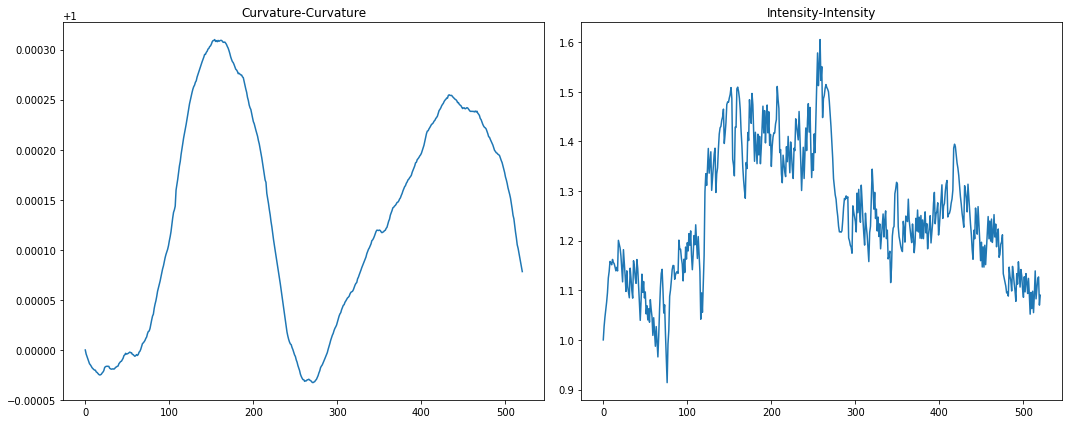

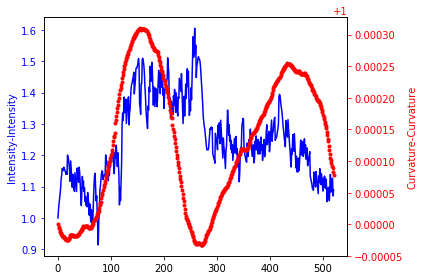

In [14]:
#Curvature and Intensity
crosscorrelation, x = CrossCorrelationStrip(imageA, imageB)
#Curvature and Curvature
autocorrelationCurve, x = CrossCorrelationStrip(imageA, imageA)
#Intensity and Intensity
autocorrelationIntensity, x = CrossCorrelationStrip(imageB, imageB)


crosscorrelation/=crosscorrelation[0]
autocorrelationCurve=autocorrelationCurve/(autocorrelationCurve[0])
autocorrelationIntensity/=autocorrelationIntensity[0]






doubleplotline(autocorrelationCurve, autocorrelationIntensity, "Curvature-Curvature","Intensity-Intensity",targetdir,Filename[0]  )


#overlaymultiplot(autocorrelationCurve,crosscorrelation,"Curvature-Curvature", "Curvature-Intensity",targetdir,Filename[0] )
overlaymultiplot(autocorrelationIntensity,autocorrelationCurve,"Intensity-Intensity", "Curvature-Curvature",targetdir,Filename[0] )
#overlaymultiplot(autocorrelationIntensity,crosscorrelation,"Intensity-Intensity", "Curvature-Intensity",targetdir,Filename[0] )






In [15]:
#Bokeh plots
p = figure(title='CC and II', x_axis_label='Perimeter', y_axis_label='Amplitude')
p.line(x, autocorrelationCurve, legend = "Cur-Curv", line_width = 2)
p.line(x, autocorrelationIntensity, legend = "Int-Int", line_width = 2, line_color='red')
output_notebook()
show(p)
export_png(p, filename=targetdir + 'CC-II' + Filename[0] + '.png')



Loading BokehJS ...

'/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/CC-IIKymographN5Circle.png'

In [16]:

q = figure(title='CC and CI', x_axis_label='Perimeter', y_axis_label='Amplitude')
q.line(x, autocorrelationCurve, legend = "Cur-Curv", line_width = 2)
q.line(x, crosscorrelation, legend = "Curv-Int", line_width = 2, line_color='red')
output_notebook()
show(q)
export_png(q, filename=targetdir + 'CC-CI' + Filename[0] + '.png')


Loading BokehJS ...

'/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/CC-CIKymographN5Circle.png'

In [17]:

r = figure(title='CI and II', x_axis_label='Perimeter', y_axis_label='Amplitude')
r.line(x, crosscorrelation, legend = "Cur-Int", line_width = 2)
r.line(x, autocorrelationIntensity, legend = "Int-Int", line_width = 2, line_color='red')
output_notebook()
show(r)
export_png(r, filename=targetdir + 'CI-II' + Filename[0] + '.png')

Loading BokehJS ...

'/Users/aimachine/Documents/KymoGraphsForFFT/NewKymographs/CI-IIKymographN5Circle.png'